In [ ]:
import shutil
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# OSM

In [ ]:
epa_path = "/content/drive/MyDrive/Capstone Project/Data/EPA_hydroWaste/Texas - Not Shortcut/"
epa_df = pd.read_csv("/content/drive/MyDrive/Capstone Project/Data/EPA_hydroWaste/verified_list.csv")
epa_df = epa_df[["filename", "State", "Owner", "WWTP_ground_truth"]]
epa_df.head()
epa_yes_files_c = epa_df[(epa_df["WWTP_ground_truth"] == "Yes") & (epa_df["State"] == "Texas")]["filename"].tolist()
epa_no_files_c = epa_df[(epa_df["WWTP_ground_truth"] == "No") & (epa_df["State"] == "Texas")]["filename"].tolist()
to_path = "/content/drive/MyDrive/Capstone Project/Data/TrainingData/Texas/No/"
for f in epa_no_files_c:
  owner = epa_df[epa_df["filename"] == f]["Owner"].values[0]
  shutil.copy(epa_path+owner+"/"+f, to_path)

In [ ]:
!pip install torchgeo

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.models.resnet import BasicBlock
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
from torchmetrics import Recall

In [ ]:
import torchgeo
import torchgeo.models as geomodels

In [ ]:
best_model_path = "best_model_resnet50.pth"  # Define where to save the best model
# path_to_save_csv = './data/random/test/predictions_50_v1_org.csv'  # Define where to save the predictions
path_to_save_csv = './data/EPA_hydroWaste/predictions_50_v1_crop_0.5.csv'  # Define where to save the predictions

In [ ]:
print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

PyTorch version: 2.2.1+cu121
device: cuda


In [ ]:
class SceneClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SceneClassifier, self).__init__()
        self.features = geomodels.resnet50(weights=torchgeo.models.ResNet50_Weights.SENTINEL2_RGB_MOCO)
        # https://pytorch.org/vision/stable/models.html
        num_ftrs = self.features.fc.in_features
        self.features.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
m_temp = geomodels.resnet50(weights=torchgeo.models.ResNet50_Weights.SENTINEL2_RGB_MOCO)

Downloading: "https://hf.co/torchgeo/resnet50_sentinel2_rgb_moco/resolve/efd9723b59a88e9dc1420dc1e96afb25b0630a3c/resnet50_sentinel2_rgb_moco-2b57ba8b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_sentinel2_rgb_moco-2b57ba8b.pth
100%|██████████| 90.0M/90.0M [00:03<00:00, 28.8MB/s]


In [ ]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomCrop(32, padding=4),  # randomly crop the image
    transforms.RandomHorizontalFlip(),  # randomly flip the image horizontally
    transforms.RandomRotation(10),  # randomly rotate the image
    transforms.RandomVerticalFlip(),  # randomly flip the image vertically
])

In [ ]:
train_dataset = ImageFolder("/content/drive/MyDrive/California_Texas_Training_Test_Split/train", transform=transform)
test_dataset = ImageFolder("/content/drive/MyDrive/California_Texas_Training_Test_Split/test", transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model = SceneClassifier(num_classes=len(train_dataset.classes)).to(device)

Downloading: "https://hf.co/torchgeo/resnet50_sentinel2_rgb_moco/resolve/efd9723b59a88e9dc1420dc1e96afb25b0630a3c/resnet50_sentinel2_rgb_moco-2b57ba8b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_sentinel2_rgb_moco-2b57ba8b.pth
100%|██████████| 90.0M/90.0M [00:00<00:00, 367MB/s]


In [ ]:
# Construct loss function object
criterion = nn.CrossEntropyLoss().to(device)

# Construct optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
best_recall = 0.0

epochs = 17

for i in range(1, epochs + 1):

    # for accuracy
    total_correct = 0
    total_samples = 0

    # for precision and recall
    predicted_labels, ground_truth_labels = [], []

    model.train()
    print("\nEpoch [{}/{}]".format(i, epochs))

    train_loader_iter = tqdm(train_loader, desc=f'Epoch {i}/{epochs}', leave=False)

    for batch_idx, (images, targets) in enumerate(train_loader_iter):
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        print("PREDICTED: ", predicted)

        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

        predicted_labels.append(predicted.cpu().detach().numpy())
        ground_truth_labels.append(targets.cpu().detach().numpy())
        # print(predicted)

    accuracy = 100 * total_correct / total_samples
    predicted_labels = np.concatenate(predicted_labels).ravel().tolist()
    ground_truth_labels = np.concatenate(ground_truth_labels).ravel().tolist()
    scores = precision_recall_fscore_support(ground_truth_labels, predicted_labels, average="micro")
    precision = scores[0]
    recall = scores[1]
    f1_score = scores[2]
    print("Scores: ", precision, recall, f1_score)
    print("Training acc: %.4f" % (accuracy))

    if recall > best_recall:
        # Save the model
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved at:", best_model_path)
        # Update the best recall value
        best_recall = recall

    # # Extract probabilities of the positive class
    # positive_probs = [prob[1] for prob in all_probs]

    # # Calculate ROC curve
    # fpr, tpr, _ = roc_curve(all_targets, positive_probs, pos_label=1)
    # roc_auc = auc(fpr, tpr)

    # # Plot ROC curve
    # plt.figure()
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic')
    # plt.legend(loc="lower right")
    # plt.show()

    # # plot the loss
    # plt.plot(loss_list)
    # plt.title('Training Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.show()



Epoch [1/17]


Epoch 1/17:   8%|▊         | 1/13 [00:03<00:47,  3.96s/it]

PREDICTED:  tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')


Epoch 1/17:  15%|█▌        | 2/13 [00:07<00:42,  3.90s/it]

PREDICTED:  tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')


Epoch 1/17:  23%|██▎       | 3/13 [00:11<00:38,  3.89s/it]

PREDICTED:  tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')


Epoch 1/17:  31%|███       | 4/13 [00:15<00:34,  3.88s/it]

PREDICTED:  tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')


Epoch 1/17:  38%|███▊      | 5/13 [00:19<00:31,  3.88s/it]

PREDICTED:  tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


Epoch 1/17:  46%|████▌     | 6/13 [00:23<00:27,  3.87s/it]

PREDICTED:  tensor([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')


Epoch 1/17:  54%|█████▍    | 7/13 [00:27<00:23,  3.85s/it]

PREDICTED:  tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')


Epoch 1/17:  62%|██████▏   | 8/13 [00:30<00:19,  3.85s/it]

PREDICTED:  tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')


Epoch 1/17:  69%|██████▉   | 9/13 [00:34<00:15,  3.89s/it]

PREDICTED:  tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')


Epoch 1/17:  77%|███████▋  | 10/13 [00:38<00:11,  3.94s/it]

PREDICTED:  tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')


Epoch 1/17:  85%|████████▍ | 11/13 [00:42<00:07,  3.91s/it]

PREDICTED:  tensor([1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')


Epoch 1/17:  92%|█████████▏| 12/13 [00:46<00:03,  3.93s/it]

PREDICTED:  tensor([1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')


PREDICTED:  tensor([0, 1], device='cuda:0')
Scores:  0.7823834196891192 0.7823834196891192 0.7823834196891192
Training acc: 78.2383


Best model saved at: best_model_resnet50.pth

Epoch [2/17]


Epoch 2/17:   8%|▊         | 1/13 [00:03<00:47,  3.97s/it]

PREDICTED:  tensor([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')


KeyboardInterrupt: 

In [ ]:
len(test_loader)

82

100%|██████████| 82/82 [24:30<00:00, 17.94s/it]


Test loss: 0.5106, Test accuracy: 79.3541
Scores:  (0.23857868020304568, 0.618421052631579, 0.3443223443223443, None)


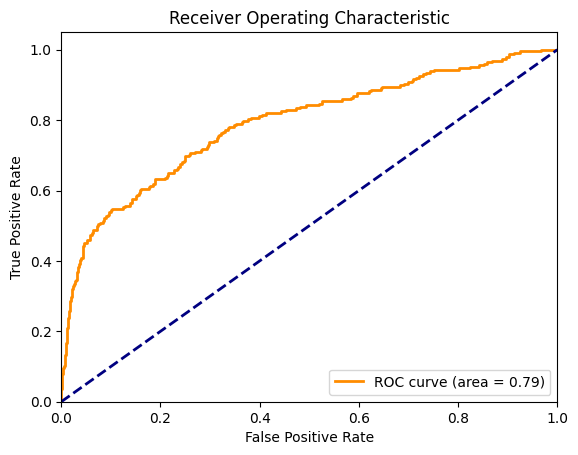

In [ ]:
def test_model(model, test_loader, criterion, device):
    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0
    all_targets = []
    all_predicted = []
    all_probs = []

    # Put model in eval mode
    model.eval()

    c_counter = 0

    # Do NOT compute gradients
    with torch.no_grad(), tqdm(total=len(test_loader)) as progress_bar:
        # Run inference on each image in the test set (use batches to make process faster)
        for batch_idx, (images, targets) in enumerate(test_loader):
            # Copy inputs to device
            images = images.to(device)
            targets = targets.to(device)
            # Forward pass images through model
            outputs = model(images)
            # Compute loss
            loss = criterion(outputs, targets)
            # Calculate correct predictions
            _, predicted = torch.max(outputs, 1)
            # Append to totals
            total_ims += targets.shape[0]
            total_batches += 1
            total_loss += loss.item()
            total_corrects += predicted.eq(targets).sum().item()
            # Append targets, predicted, and probabilities for precision, recall, and ROC curve calculation
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
            all_probs.extend(nn.functional.softmax(outputs, dim=1).cpu().numpy())
            progress_bar.update(1)
            c_counter += 1

    avg_loss = total_loss / total_batches
    acc = (total_corrects / total_ims) * 100.0
    print("Test loss: %.4f, Test accuracy: %.4f" % (avg_loss, acc))

    # Calculate precision, recall, and F1 score
    # precision = precision_score(all_targets, all_predicted, average='macro')
    # recall = recall_score(all_targets, all_predicted, average='macro')
    # f1 = f1_score(all_targets, all_predicted, average='macro')

    # print("Precision: %.4f, Recall: %.4f, F1 Score: %.4f" % (precision, recall, f1))
    scores = precision_recall_fscore_support(all_targets, all_predicted, average="binary")
    print("Scores: ", scores)

    # Extract probabilities of the positive class
    positive_probs = [prob[1] for prob in all_probs]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(all_targets, positive_probs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Load the best weights saved during training
# model.load_state_dict(torch.load(best_model_path))

# Call test_model
test_model(model, test_loader, criterion, device)